In [16]:
# Import standard libraries
import numpy as np
import matplotlib.pyplot as plt
import camb
from camb import model

basepath = '/data/'

In [17]:
def compute_multipoles_model(CosmoParams, zeff, kmax = 0.1):
    # Cosmological parameters
    h, omega_b, omega_cdm, ns, log10As, Mnu, b1 = CosmoParams
    # Getting ready CAMB
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=h*100, ombh2=omega_b, omch2=omega_cdm, omk=0.0, 
                       tau=0.0561, standard_neutrino_neff=3.04, num_massive_neutrinos=1, 
                       neutrino_hierarchy='normal', mnu=Mnu, nnu=3.04)
    pars.InitPower.set_params(ns=ns, As=np.exp(log10As)/1e10)
    pars.set_matter_power(kmax=kmax, redshifts=[zeff, zeff + 0.001])
    results = camb.get_results(pars)
    # Get Power spectrum of matter
    k_full, _, PK = results.get_linear_matter_power_spectrum(hubble_units=True, k_hunit=True)
    Pk = PK[0,:]
    # Get Power spectrum of baryons+CDM at the two redshift (for computing the growth rate f_cb(k) later)
    _, _, PK_cb = results.get_linear_matter_power_spectrum(var1='delta_nonu', var2='delta_nonu', hubble_units=True, k_hunit=True)
    Pk_cb = PK_cb[0,:]
    Pk_cb_z2 = PK_cb[1,:]
    # Get transfer functions of cb and matter
    trans = results.get_matter_transfer_data()
    T_m = trans.transfer_data[model.Transfer_tot-1,:,0]
    T_cb = trans.transfer_data[model.Transfer_nonu-1,:,0]
    # Computing f_cb(k) around z = zeff
    a1 = 1.0 / (1.0 + zeff)
    a2 = 1.0 / (1.0 + zeff + 0.001)
    dlnP = np.log(Pk_cb_z2) - np.log(Pk_cb)
    dln_a = np.log(a2) - np.log(a1)
    f_cb = 0.5 * dlnP / dln_a
    # Get the bias of galaxies with respect to the total matter
    bm = b1*(T_cb/T_m)
    # Get the effective growth rate with respect to the total matter
    f_eff = f_cb*(T_cb / T_m)
    # Define mu values
    mu_vals = np.linspace(-1, 1, len(Pk))
    # Computing the power spectrum with RSDs 
    P_k_mu = np.array([bm**2*(1 + f_eff/bm * mu_i**2)**2 * Pk for mu_i in mu_vals])
    P_k_mu =  P_k_mu.T
    # Define Legendre polynomials of Legendre
    def L0(mu):
        return np.ones_like(mu)
    def L2(mu):
        return 0.5 * (3 * mu**2 - 1)
    def L4(mu):
        return (35 * mu**4 - 30 * mu**2 + 3) / 8
    # Compute Legendre polynomials
    L_ell0 = L0(mu_vals)
    L_ell2 = L2(mu_vals)
    L_ell4 = L4(mu_vals)
    # Multiply each row in P_k_mu by the Legendre polynomials
    integrand0 = P_k_mu * L_ell0[np.newaxis, :]
    integrand2 = P_k_mu * L_ell2[np.newaxis, :]
    integrand4 = P_k_mu * L_ell4[np.newaxis, :]
    # Integrate over μ using trapezoidal rule along axis=1 (μ-axis)
    integral0 = np.trapz(integrand0, x=mu_vals, axis=1)
    integral2 = np.trapz(integrand2, x=mu_vals, axis=1)
    integral4 = np.trapz(integrand4, x=mu_vals, axis=1)
    # Multipole prefactors
    P_ell0 = 0.5 * integral0
    P_ell2 = 2.5 * integral2
    P_ell4 = 4.5 * integral4
    # Interpolate Pk, Pk_cb and transfer funcions in the bining of k
    k_fn = (basepath + 'k.txt')
    k_arr = np.loadtxt(k_fn)
    mask = k_arr <= kmax
    k_arr = k_arr[mask]
    P_ell0  = np.interp(k_arr, k_full, P_ell0)
    P_ell2  = np.interp(k_arr, k_full, P_ell2)
    P_ell4  = np.interp(k_arr, k_full, P_ell4)    
    # Return multipoles
    return k_arr, P_ell0, P_ell2, P_ell4

In [18]:
# Dowload the data
# k modes range
k_fn = (basepath + 'k.txt')
k_arr = np.loadtxt(k_fn)
# Monopole
Pk0_fn = (basepath + 'Pk_0.txt')
Pk0 = np.loadtxt(Pk0_fn)
# Quadrupole
Pk2_fn = (basepath + 'Pk_2.txt')
Pk2 = np.loadtxt(Pk2_fn)
# Hexadecapole
Pk4_fn = (basepath + 'Pk_4.txt')
Pk4 = np.loadtxt(Pk4_fn)
# Covariance matrix
cov_fn = (basepath + 'cov.txt')
cov = np.loadtxt(cov_fn)

# Cutting at some kmax scale
kmax = 0.08
# Cut the cov matrix
def cut_matrix(cov, xcov, ellscov, xlim):
    assert len(cov) == len(xcov) * len(ellscov), 'Input matrix has size {}, different than {} x {}'.format(len(cov), len(xcov), len(ellscov))
    indices = []
    for ell, xlim in xlim.items():
        index = ellscov.index(ell) * len(xcov) + np.arange(len(xcov))
        index = index[(xcov >= xlim[0]) & (xcov <= xlim[1])]
        indices.append(index)
    indices = np.concatenate(indices, axis=0)
    return cov[np.ix_(indices, indices)]
cov_fn = (basepath + 'cov.txt')
cov = np.loadtxt(cov_fn)
kcenters = k_arr  # x-axis values used to index the covariance matrix
ellscov = (0, 2, 4)  # multipole orders in the full data vector
klim = {ell: (k_arr[0], kmax, 0.005) for ell in ellscov}
# Apply the cut
cov = cut_matrix(cov, kcenters, ellscov, klim)
# Cut the k modes
mask = k_arr <= kmax
k_arr = k_arr[mask]
# Cut the multipoles
Pk0 = Pk0[mask]
Pk2 = Pk2[mask]
Pk4 = Pk4[mask]

# Extract standard deviations from the diagonal
sigma0 = np.sqrt(np.diag(cov)[0:len(k_arr)])
sigma2 = np.sqrt(np.diag(cov)[len(k_arr):2*len(k_arr)])
sigma4 = np.sqrt(np.diag(cov)[2*len(k_arr):3*len(k_arr)])

In [19]:
# Cosmological parameters
# Hubble
h = 0.6736
# Baryons
omega_b = 0.02237
# Cold Dark Matter
omega_cdm = 0.1200
# Scalar spectral index
ns = 0.9649
# Scalar amplitude
log10As = np.log(1e10*2.0830e-9)
# Neutrino mass
Mnu = 0.00064420*94.14
# Linear bias
b1 = 1.98
# Redshift
zeff = 0.8

CosmoParams_fid = [h, omega_b, omega_cdm, ns, log10As, Mnu, b1]
_, P_ell0, P_ell2, P_ell4 = compute_multipoles_model(CosmoParams_fid, zeff, kmax=kmax)

Note: redshifts have been re-sorted (earliest first)


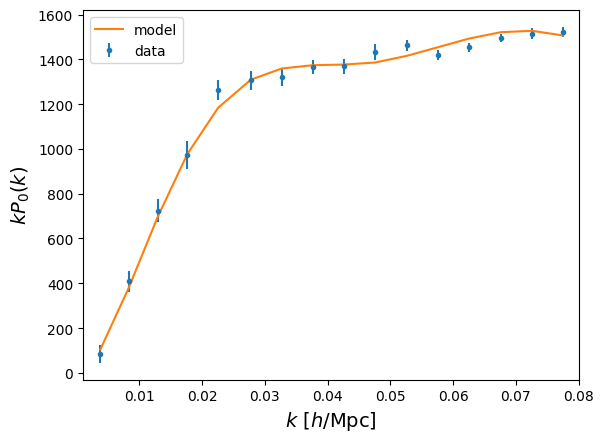

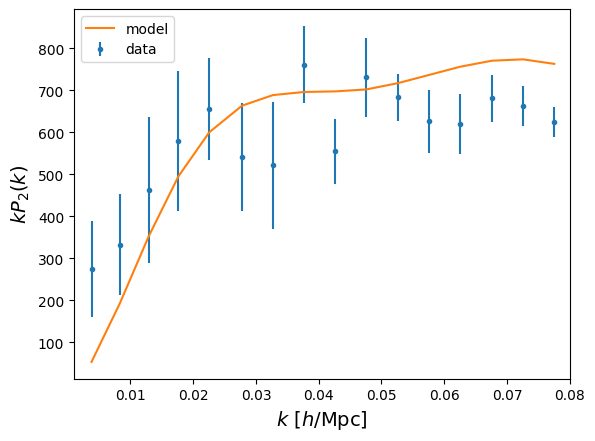

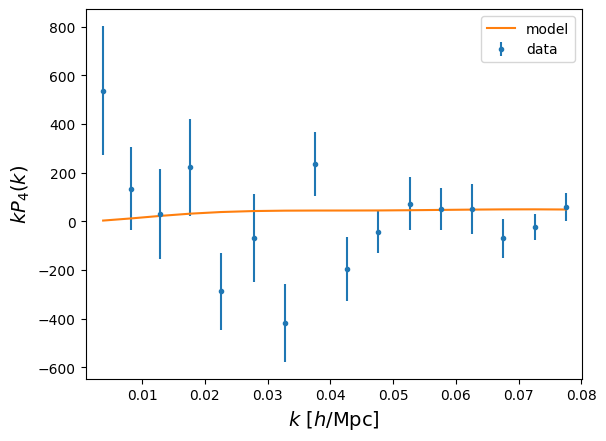

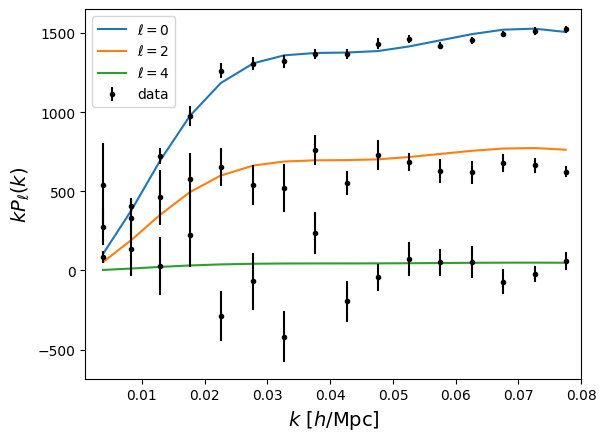

In [20]:
# Plot
plt.errorbar(k_arr, k_arr * Pk0[:,0], yerr=k_arr * sigma0, fmt='o', markersize=3, label=r'data')
plt.plot(k_arr, k_arr * P_ell0, label=r'model')
plt.xlabel(r'$k$ [$h$/Mpc]', fontsize=14)
plt.ylabel(r'$kP_0(k)$', fontsize=14)
plt.xlim(1e-3,np.max(k_arr)+0.0025)
plt.legend()
plt.show()

plt.errorbar(k_arr, k_arr * Pk2[:,0], yerr=k_arr * sigma2, fmt='o', markersize=3, label=r'data')
plt.plot(k_arr, k_arr * P_ell2, label=r'model')
plt.xlabel(r'$k$ [$h$/Mpc]', fontsize=14)
plt.ylabel(r'$kP_2(k)$', fontsize=14)
plt.xlim(1e-3,np.max(k_arr)+0.0025)
plt.legend()
plt.show()

plt.errorbar(k_arr, k_arr * Pk4[:,0], yerr=k_arr * sigma4, fmt='o', markersize=3, label=r'data')
plt.plot(k_arr, k_arr * P_ell4, label=r'model')
plt.xlabel(r'$k$ [$h$/Mpc]', fontsize=14)
plt.ylabel(r'$kP_4(k)$', fontsize=14)
plt.xlim(1e-3,np.max(k_arr)+0.0025)
plt.legend()
plt.show()

plt.plot(k_arr, k_arr * P_ell0, label=r'$\ell = 0$')
plt.plot(k_arr, k_arr * P_ell2, label=r'$\ell = 2$')
plt.plot(k_arr, k_arr * P_ell4, label=r'$\ell = 4$')
plt.errorbar(k_arr, k_arr * Pk0[:,0], yerr=k_arr * sigma0, fmt='o', markersize=3, color='k', label=r'data')
plt.errorbar(k_arr, k_arr * Pk2[:,0], yerr=k_arr * sigma2, fmt='o', markersize=3, color='k')
plt.errorbar(k_arr, k_arr * Pk4[:,0], yerr=k_arr * sigma4, fmt='o', markersize=3, color='k')
plt.xlabel(r'$k$ [$h$/Mpc]', fontsize=14)
plt.ylabel(r'$kP_{\ell}(k)$', fontsize=14)
plt.xlim(1e-3,np.max(k_arr)+0.0025)
plt.legend()
plt.show()